# **PREDICTION AVERAGE TEMPERATURE OF ISTANBUL CITY IN TURKEY WITH LSTM METHOD**

<font color='darkred'>
Content:
    
1. [Load Data](#1)
2. [Visualization](#2)
3. [Selecting Special City](#3)
4. [Future Engineering: Adding Columns and Visualization](#4)
5. [Missing Values](#5)
6. [Predictions with LSTM](#6)
    * [Hyper Tuning for Prediction](#7)

In [190]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import plotly.express as px
import seaborn as sns
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
from scipy import stats
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import os
sns.set(style="whitegrid")
%matplotlib inline
import time
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import yellowbrick 
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Concatenate
import warnings
warnings.filterwarnings("ignore")
title_font= {"family": "arial", "weight": "bold", "color": "darkred", "size":13}
label_font= {"family": "arial", "weight": "bold", "color": "darkblue", "size":10}
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
pd.options.mode.chained_assignment = None

/kaggle/input/climate-change-earth-surface-temperature-data/GlobalTemperatures.csv
/kaggle/input/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByState.csv
/kaggle/input/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByCountry.csv
/kaggle/input/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByCity.csv
/kaggle/input/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByMajorCity.csv


### I will use **GlobalLandTemperaturesByCity** dataset:

<a id='1'></a>
## **1. Load the dataset:**

In [191]:
global_temp_city= pd.read_csv("/kaggle/input/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByCity.csv")

In [192]:
global_temp_city.rename(columns = {'dt':'Date'}, inplace = True)

## Narrowing the dataset by Turkey:

In [193]:
Turkey_global=global_temp_city[global_temp_city.Country=="Turkey"]
print(Turkey_global.City.unique())
print("There are {} cities.".format(Turkey_global.City.nunique()))


['Çorlu' 'Çorum' 'Adana' 'Afyonkarahisar' 'Aksaray' 'Alanya' 'Ankara'
 'Antakya' 'Antalya' 'Batman' 'Bursa' 'Denizli' 'Edirne' 'Erzincan'
 'Erzurum' 'Esenyurt' 'Eskisehir' 'Gaziantep' 'Gebze' 'Inegol'
 'Iskenderun' 'Isparta' 'Istanbul' 'Izmir' 'Izmit' 'Kütahya'
 'Kahramanmaras' 'Karaman' 'Kayseri' 'Konya' 'Malatya' 'Manisa' 'Mersin'
 'Nazilli' 'Ordu' 'Osmaniye' 'Samsun' 'Siirt' 'Sivas' 'Siverek' 'Tarsus'
 'Tekirdag' 'Tokat' 'Trabzon' 'Turgutlu' 'Turhal' 'Urfa' 'Usak' 'Van'
 'Viransehir' 'Zonguldak']
There are 51 cities.


## In Global Temperature by City dataset, I just parsed the Turkey data and printed the existing cities. There are 51 cities in Turkey dataset. 

<a id='2'></a>
## **2. Visualization**

In [194]:
Turkey_cities=list(Turkey_global.City.unique())

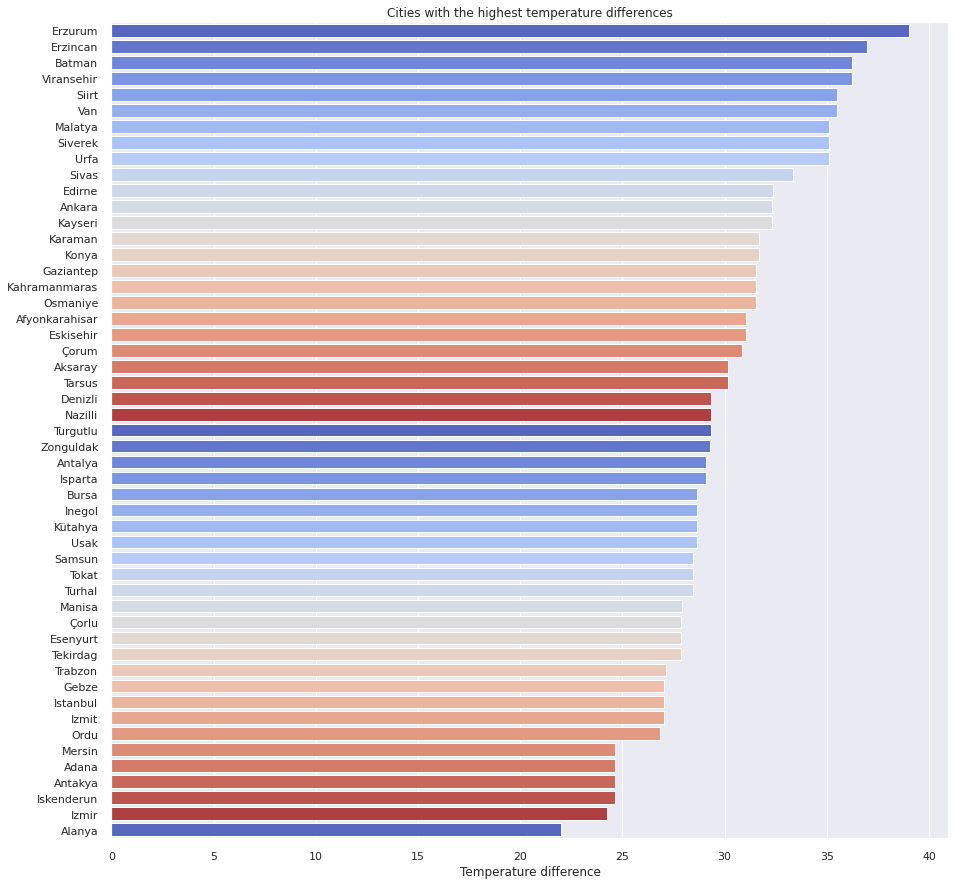

In [195]:
Turkey_cities
min_max_list = []

# getting max and min temps
for city in Turkey_cities:

        ##print(city)
        curr_temps = Turkey_global[Turkey_global['City'] == city]['AverageTemperature']
        curr_temps_uncertain = Turkey_global[Turkey_global['City'] == city]['AverageTemperatureUncertainty']
        min_max_list.append((curr_temps.max(), curr_temps.min()))

# calc differences        
differences = []

for tpl in min_max_list:
    differences.append(tpl[0] - tpl[1])
    
# sorting
differences, Turkey_cities = (list(x) for x in zip(*sorted(zip(differences, Turkey_cities), key=lambda pair: pair[0], reverse=True)))

# ploting cities with temperature difference
f, ax = plt.subplots(figsize=(15,15))
sns.barplot(x=differences, y=Turkey_cities, palette=sns.color_palette("coolwarm", 25), ax=ax)

texts = ax.set(ylabel="", xlabel="Temperature difference", title="Cities with the highest temperature differences")

### The figure shows that Erzurum has highest temperature differences, Alanya has lowest differences.

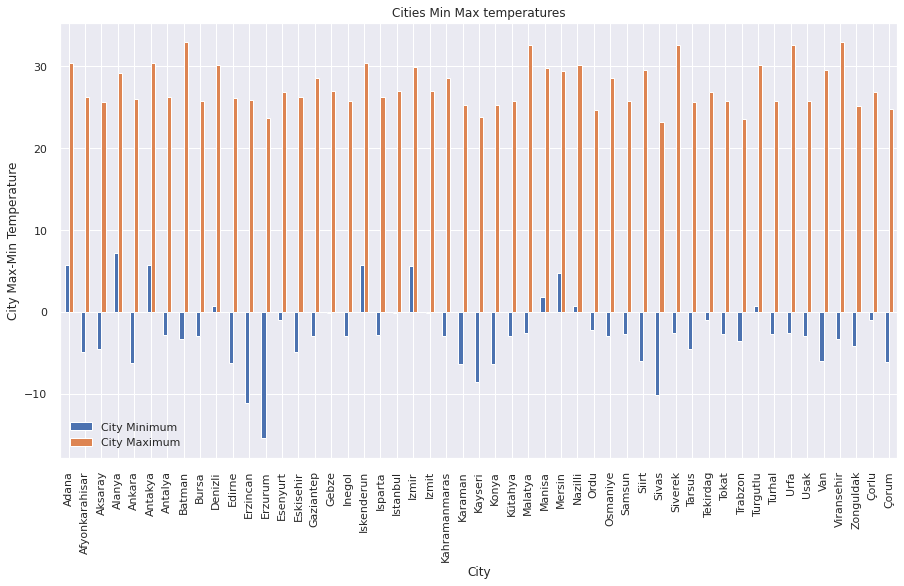

In [196]:
min_max_city = pd.DataFrame(Turkey_global)

max_city = min_max_city.groupby(['City']).max()['AverageTemperature']
max_city = max_city.to_frame().reset_index()
max_city.columns = ['City','City Maximum']
max_city = max_city.loc[max_city['City'].isin(Turkey_cities)]

min_city = min_max_city.groupby(['City'],as_index=True).min()['AverageTemperature']
min_city = min_city.to_frame().reset_index()
min_city.columns = ['City','City Minimum']
##print(min_majorcity)
min_city = min_city.loc[min_city['City'].isin(Turkey_cities)]

##Merging the two data sets
min_max_merge = pd.merge(min_city , max_city)
min_max_merge = min_max_merge.set_index('City')
##print(min_max_majorcity_merge)

ax = min_max_merge.plot(kind='bar',stacked=False, figsize=(15, 8))

texts = ax.set(ylabel="City Max-Min Temperature", xlabel="City", title="Cities Min Max temperatures")

### Erzurum has lowest temperature; Kütahya and Batman have highest temperature

<a id='3'></a>
## **3. Selecting Special City: Istanbul**

### I choose a city that is Istanbul. I will use Istanbul datas for prediction my project.

In [197]:
Ist=Turkey_global[Turkey_global.City=="Istanbul"]
Ist

,Date,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
3256834,1743-11-01,10.365,2.325,Istanbul,Turkey,40.99N,29.82E
3256835,1743-12-01,NaN,NaN,Istanbul,Turkey,40.99N,29.82E
3256836,1744-01-01,NaN,NaN,Istanbul,Turkey,40.99N,29.82E
3256837,1744-02-01,NaN,NaN,Istanbul,Turkey,40.99N,29.82E
3256838,1744-03-01,NaN,NaN,Istanbul,Turkey,40.99N,29.82E
...,...,...,...,...,...,...,...
3260068,2013-05-01,19.384,0.273,Istanbul,Turkey,40.99N,29.82E
3260069,2013-06-01,21.853,0.504,Istanbul,Turkey,40.99N,29.82E
3260070,2013-07-01,23.553,0.515,Istanbul,Turkey,40.99N,29.82E
3260071,2013-08-01,24.724,0.485,Istanbul,Turkey,40.99N,29.82E


### I can drop Longitude and Latitude columns because of same values for Istanbul. Then, I can drop Country column.

In [198]:
Ist.drop(labels = ["Latitude","Longitude","Country"], axis = 1, inplace = True)

In [199]:
Ist.describe()

,AverageTemperature,AverageTemperatureUncertainty
count,3166.000000,3166.000000
mean,13.507409,1.444198
std,6.646425,1.334713
min,-0.090000,0.083000
25%,7.503500,0.394000
50%,13.415000,0.896000
75%,19.843250,2.218750
max,26.954000,8.302000


### Mean and %50 values are similar each other for Average Temperature, so that is must be normally distribution.

In [200]:
print("First year:", global_temp_city.Date.min())
print("Last year:", global_temp_city.Date.max())


First year: 1743-11-01
Last year: 2013-09-01


### There is 270 years from begining to ending years.

In [201]:
Ist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3239 entries, 3256834 to 3260072
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date                           3239 non-null   object 
 1   AverageTemperature             3166 non-null   float64
 2   AverageTemperatureUncertainty  3166 non-null   float64
 3   City                           3239 non-null   object 
dtypes: float64(2), object(2)
memory usage: 126.5+ KB


### So, there are 4 columns and 3239 entriesI have. There are not much null values. Almost half of values are object. I have to change these as integer.

In [202]:
Ist.isnull().sum()

Date                              0
AverageTemperature               73
AverageTemperatureUncertainty    73
City                              0
dtype: int64

<a id='4'></a>
## **4. Future Engineering: Adding Columns and Visualization**

### As can be seen above table, there is so less null values. I can drop the values bu I will fill the values with its mean. And I can add a new features.

### As **Season and months**:

In [203]:
Ist["Year"] = pd.DatetimeIndex(Ist['Date']).year
Ist["Month"] = pd.DatetimeIndex(Ist['Date']).month
Ist['Month'] = Ist['Month'].astype(str) 
Ist.loc[Ist['Month']=='1','Month'] = 'January'
Ist.loc[Ist['Month']=='2','Month'] = 'February'
Ist.loc[Ist['Month']=='3','Month'] = 'March'
Ist.loc[Ist['Month']=='4','Month'] = 'April'
Ist.loc[Ist['Month']=='5','Month'] = 'May'
Ist.loc[Ist['Month']=='6','Month'] = 'June'
Ist.loc[Ist['Month']=='7','Month'] = 'July'
Ist.loc[Ist['Month']=='8','Month'] = 'August'
Ist.loc[Ist['Month']=='9','Month'] = 'September'
Ist.loc[Ist['Month']=='10','Month'] = 'October'
Ist.loc[Ist['Month']=='11','Month'] = 'November'
Ist.loc[Ist['Month']=='12','Month'] = 'December'
year_month = Ist.groupby(by = ['Year','Month']).mean().reset_index()


In [204]:
import plotly.graph_objects as go
month_season = {
    "January": "Winter",
    "February": "Winter",
    "March": "Spring",
    "April": "Spring",
    "May": "Spring",
    "June": "Summer",
    "July": "Summer",
    "August": "Summer",
    "September": "Autumn",
    "October": "Autumn",
    "November": "Autumn",
    "December": "Winter"
}

Ist['Season'] = ''

for month, season in month_season.items():
    Ist.loc[Ist['Month'] == month, 'Season'] = season

year_season = Ist.groupby(by = ['Year','Season']).mean().reset_index()

Winter = year_season.loc[year_season['Season'] == 'Winter',:]
Spring = year_season.loc[year_season['Season'] == 'Spring',:]
Summer = year_season.loc[year_season['Season'] == 'Summer',:]
Autumn = year_season.loc[year_season['Season'] == 'Autumn',:]

fig2 = go.Figure()
for template in ["plotly_white"]:
    fig2.add_trace(go.Scatter(x=Winter['Year'], y=Winter['AverageTemperature'],
                    mode='lines',
                    name='Winter',
                    marker_color='#838B8B'))
    fig2.add_trace(go.Scatter(x=Spring['Year'], y=Spring['AverageTemperature'],
                    mode='lines',
                    name='Spring',
                    marker_color='#FFB5C5'))
    fig2.add_trace(go.Scatter(x=Summer['Year'], y=Summer['AverageTemperature'],
                    mode='lines',
                    name='Summer',
                    marker_color='#87CEFF'))
    fig2.add_trace(go.Scatter(x=Autumn['Year'], y=Autumn['AverageTemperature'],
                    mode='lines',
                    name='Autumn',
                    marker_color='#FF8000'))
    fig2.update_layout(
    height=800,
    xaxis_title="Years",
    yaxis_title='Temperature in degree',
    title_text='Average Temperature seasonwise over the years',
    template=template)




fig2.show()

### One step forward, there is a season information thanks to month datas. I can add a season column my dataset. It will be easier for prediction. In the figure, there are average temperatures by seasons and years. As can be seen, although there is usually a fluctuating graph in details, the results are almost similar on average.

Text(0, 0.5, 'Temperature')

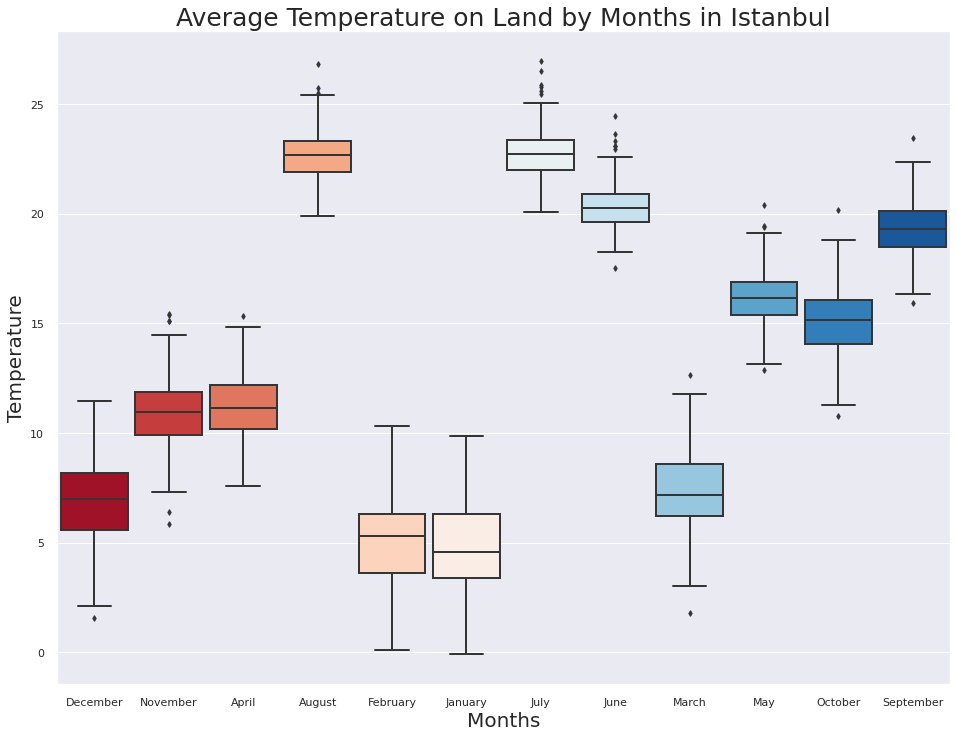

In [205]:
Ist["Year"] = pd.DatetimeIndex(Ist['Date']).year
Ist["Month"] = pd.DatetimeIndex(Ist['Date']).month
Ist['Month'] = Ist['Month'].astype(str) 
Ist.loc[Ist['Month']=='1','Month'] = 'January'
Ist.loc[Ist['Month']=='2','Month'] = 'February'
Ist.loc[Ist['Month']=='3','Month'] = 'March'
Ist.loc[Ist['Month']=='4','Month'] = 'April'
Ist.loc[Ist['Month']=='5','Month'] = 'May'
Ist.loc[Ist['Month']=='6','Month'] = 'June'
Ist.loc[Ist['Month']=='7','Month'] = 'July'
Ist.loc[Ist['Month']=='8','Month'] = 'August'
Ist.loc[Ist['Month']=='9','Month'] = 'September'
Ist.loc[Ist['Month']=='10','Month'] = 'October'
Ist.loc[Ist['Month']=='11','Month'] = 'November'
Ist.loc[Ist['Month']=='12','Month'] = 'December'
year_month = Ist.groupby(by = ['Year','Month']).mean().reset_index()
# Figure size
plt.figure(figsize=(16,12))

# The plot
sns.boxplot(x = 'Month', y = 'AverageTemperature', data = year_month, palette = "RdBu", saturation = 1, width = 0.9, fliersize=4, linewidth=2)

# Make pretty
plt.title('Average Temperature on Land by Months in Istanbul', fontsize = 25)
plt.xlabel('Months', fontsize = 20)
plt.ylabel('Temperature', fontsize = 20)

### As can be seen the figure, there are average temperatures by months. In January, the lowest average temperature. Otherwise, Agust and July have the highest average temperature.

<a id='5'></a>
## **5. Missing Values**

In [206]:
Ist['AverageTemperature'] = Ist['AverageTemperature'].groupby([Ist['Season'], Ist['City']]).apply(lambda x: x.fillna(x.mean()))

In [207]:
Ist['AverageTemperatureUncertainty'] = Ist['AverageTemperatureUncertainty'].groupby([Ist['Season'], Ist['City']]).apply(lambda x: x.fillna(x.mean()))

### Then I can use **get.dummies** method for categorical columns:

In [208]:
Ist=pd.concat([Ist, pd.get_dummies(Ist["Season"], prefix="Season", prefix_sep="_")], axis=1)

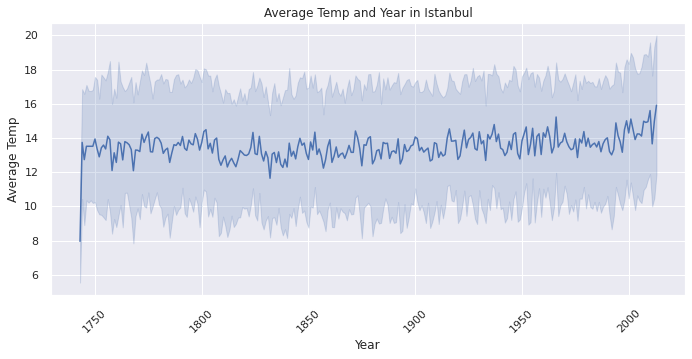

In [209]:
plt.figure(figsize=(25, 5))
plt.subplot(121)
sns.lineplot(x = Ist["Year"], y = Ist["AverageTemperature"])
plt.title("Average Temp and Year in Istanbul")
plt.xlabel("Year")
plt.ylabel("Average Temp")
plt.xticks(rotation = 45)
plt.show()

### There is a average temperature of Istanbul from 1750 to 2013. The average  value approximately is 14 degree.

### I will select datas for after 1950s:

In [210]:
Ist=Ist[3000:]

<a id='6'></a>
## **6. Predictions with LSTM**

## For prediction, I can use **LSTM** method because I have time series. LSTM methos i very useful for time series. I select my input data as average temperature. My lookback value is 30. eopch value is 400 and batch size value is 60.

In [211]:
input_data = Ist.iloc[:,[1,2]].values

from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler(feature_range=(0,1))
input_data[:,0:2] = sc.fit_transform(input_data[:,:])

lookback= 30

test_size=int(.3 * len(Ist))
X=[]
y=[]
for i in range(len(Ist)-lookback-1):
    t=[]
    for j in range(0,lookback):
        t.append(input_data[[(i+j)], :])
    X.append(t)
    y.append(input_data[i+ lookback,1])

X, y= np.array(X), np.array(y)
X_test = X[:test_size+lookback]
X = X.reshape(X.shape[0],lookback, 2)
X_test = X_test.reshape(X_test.shape[0],lookback, 2)

model = Sequential()
model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],2)))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=1))
model.summary()

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X, y, epochs=400, batch_size=60, verbose=0)

predictions= model.predict(X_test)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 30, 30)            3960      
_________________________________________________________________
lstm_13 (LSTM)               (None, 30, 30)            7320      
_________________________________________________________________
lstm_14 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 31        
Total params: 18,631
Trainable params: 18,631
Non-trainable params: 0
_________________________________________________________________


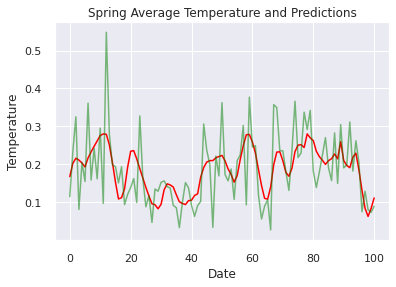

In [212]:
plt.plot(predictions, color= 'red')
plt.plot(input_data[lookback:test_size+(2*lookback),1], color='green',alpha=0.5)
plt.title("Spring Average Temperature and Predictions")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.show()

### As can be seen above, there is a very good result for prediction. The pretiction line and original is so close to each other. Otherwise, I can do better for this. I will chance epoch and bach size values as 600 and 80 respectively:

<a id='7'></a>
## **6.1 Hyper Tuning for Prediction**

In [213]:
input_data = Ist.iloc[:,[1,2]].values

from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler(feature_range=(0,1))
input_data[:,0:2] = sc.fit_transform(input_data[:,:])

lookback= 30

test_size=int(.3 * len(Ist))
X=[]
y=[]
for i in range(len(Ist)-lookback-1):
    t=[]
    for j in range(0,lookback):
        t.append(input_data[[(i+j)], :])
    X.append(t)
    y.append(input_data[i+ lookback,1])

X, y= np.array(X), np.array(y)
X_test = X[:test_size+lookback]
X = X.reshape(X.shape[0],lookback, 2)
X_test = X_test.reshape(X_test.shape[0],lookback, 2)

model = Sequential()
model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],2)))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=1))
model.summary()

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X, y, epochs=600, batch_size=80, verbose=0)

predictions= model.predict(X_test)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 30, 30)            3960      
_________________________________________________________________
lstm_16 (LSTM)               (None, 30, 30)            7320      
_________________________________________________________________
lstm_17 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 31        
Total params: 18,631
Trainable params: 18,631
Non-trainable params: 0
_________________________________________________________________


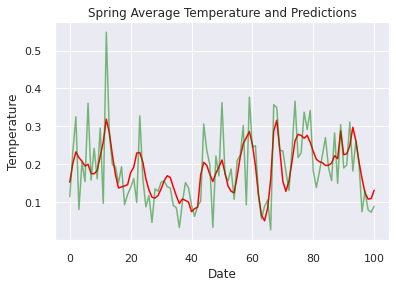

In [214]:
plt.plot(predictions, color= 'red')
plt.plot(input_data[lookback:test_size+(2*lookback),1], color='green',alpha=0.5)
plt.title("Spring Average Temperature and Predictions")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.show()

## As predicted, when I changed the epoch and bach size values, the estimation gave me more accurate results.